In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')
# Step 1: Load and Prepare the Data
# Assuming data['Date'] column and the 'Supply' column already exist

# Convert Date column to datetime and sort
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')
data['Supply'] = data['Supply'].str.replace(',', '').astype(float)

# Add lagged features to give the model more context on recent values
data['Supply_lag1'] = data['Supply'].shift(1)
data['Supply_lag7'] = data['Supply'].shift(7)
data['Supply_lag14'] = data['Supply'].shift(14)
data['Supply_lag30'] = data['Supply'].shift(30)
data['Supply_lag72'] = data['Supply'].shift(72)

# Add rolling mean as a feature for short-term trends
data['Supply_MA7'] = data['Supply'].rolling(window=7).mean()
data['Supply_MA30'] = data['Supply'].rolling(window=30).mean()

# Drop NaN values after feature engineering
data.dropna(inplace=True)

# Create target and feature variables
target = 'Supply'
features = ['72 Day Temperature', '72 Day Precipitation', 'Harvest Volume (tons/day)', 
            'Supply_lag1', 'Supply_lag7', 'Supply_lag14', 'Supply_lag30', 'Supply_lag72', 'Supply_MA7', 'Supply_MA30']
y = data[target]
X = data[features]


In [3]:
# Step 2: Train-Test Split
train_size = int(0.8 * len(y))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 3: Scale the features (optional)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train LightGBM Model
# Prepare the LightGBM dataset
train_data = lgb.Dataset(X_train_scaled, label=y_train)

# Set LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the model
lgb_model = lgb.train(params, train_data, num_boost_round=500)


RMSE of LightGBM Model: 1725527.7443867675


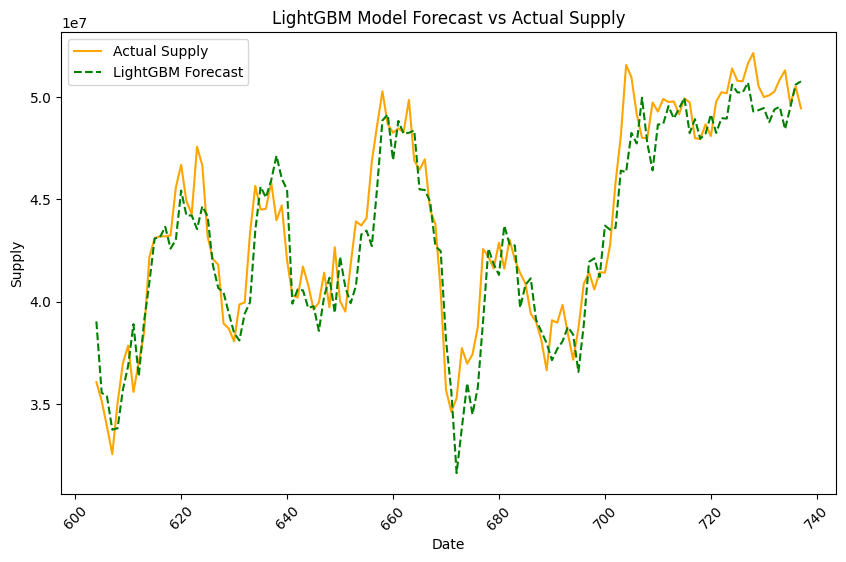

In [4]:
# Step 5: Make Predictions
y_pred = lgb_model.predict(X_test_scaled)

# Step 6: Evaluate the Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE of LightGBM Model: {rmse}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Supply', color='orange')
plt.plot(y_test.index, y_pred, label='LightGBM Forecast', linestyle='--', color='green')
plt.legend()
plt.title('LightGBM Model Forecast vs Actual Supply')
plt.xlabel('Date')
plt.ylabel('Supply')
plt.xticks(rotation=45)
plt.show()

In [5]:
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE of LightGBM Model: {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE of LightGBM Model: {mae}")

# R-squared (R^2)
r2 = r2_score(y_test, y_pred)
print(f"R^2 of LightGBM Model: {r2}")

# Explained Variance Score
explained_variance = explained_variance_score(y_test, y_pred)
print(f"Explained Variance Score of LightGBM Model: {explained_variance}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE of LightGBM Model: {mape}%")


RMSE of LightGBM Model: 1725527.7443867675
MAE of LightGBM Model: 1363348.238171324
R^2 of LightGBM Model: 0.877686288317193
Explained Variance Score of LightGBM Model: 0.8888620421826912
MAPE of LightGBM Model: 3.1717208458024735%


C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Patron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X

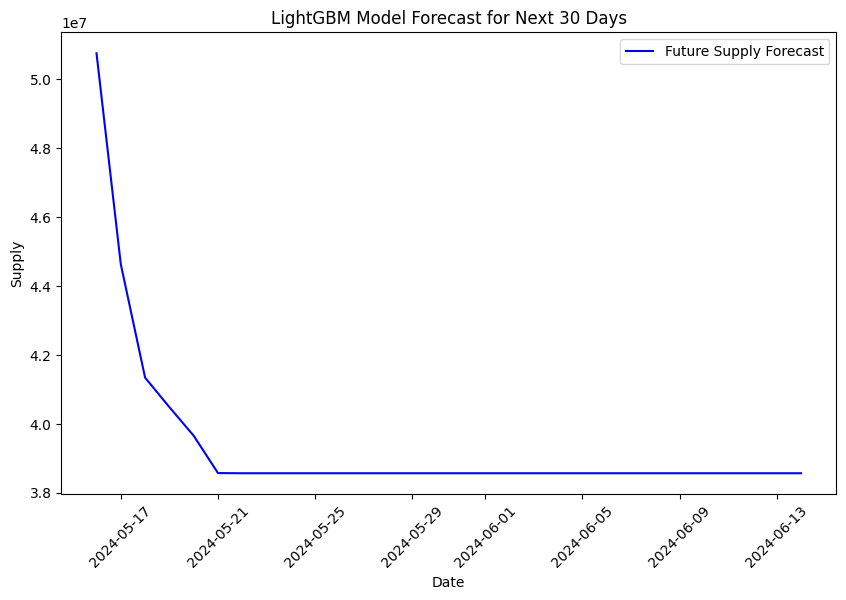

In [6]:
# Step 7: Predict Supply for the Next 30 Days
# Get the last available row of data for prediction
last_row = X.iloc[-1]
last_scaled = scaler.transform([last_row])

future_predictions = []
current_input = last_scaled

for i in range(30):
    # Predict the next day's supply
    next_supply = lgb_model.predict(current_input)[0]
    future_predictions.append(next_supply)
    
    # Create a new row of features by shifting the lagged values
    new_row = current_input[0].copy()
    new_row[3] = next_supply  # Update Supply_lag1 with the latest prediction
    new_row[4] = new_row[3]   # Update Supply_lag7 (approximate for simplicity)
    new_row[5] = new_row[4]   # Update Supply_lag14 (approximate for simplicity)
    new_row[6] = new_row[5]   # Update Supply_lag30 (approximate for simplicity)
    new_row[7] = new_row[6]   # Update Supply_lag72 (approximate for simplicity)
    
    # Update the current input for the next iteration
    current_input = scaler.transform([new_row])

# Create a DataFrame to store future predictions
dates_future = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)
future_supply_df = pd.DataFrame({'Date': dates_future, 'Predicted_Supply': future_predictions})

# Plot future predictions
plt.figure(figsize=(10, 6))
plt.plot(future_supply_df['Date'], future_supply_df['Predicted_Supply'], label='Future Supply Forecast', color='blue')
plt.title('LightGBM Model Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Supply')
plt.xticks(rotation=45)
plt.legend()
plt.show()
